# Pest Classification with Transfer Learning

# Importing Libraries

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import random
from sklearn.metrics import classification_report, confusion_matrix

# Loading the Data

In [3]:
dataset_path = '../datasets'

# Parameters
batch_size = 32
img_height = 224
img_width = 224
validation_split = 0.2
seed = 123

# Create the training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=validation_split,
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical',
)

# Create the validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=validation_split,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical',
)

Found 5494 files belonging to 12 classes.
Using 4396 files for training.
Found 5494 files belonging to 12 classes.
Using 1098 files for validation.


# Visualizing Samples from the Dataset

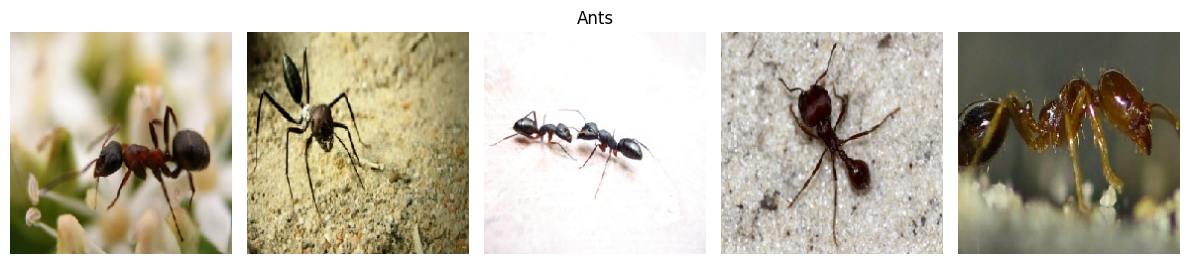

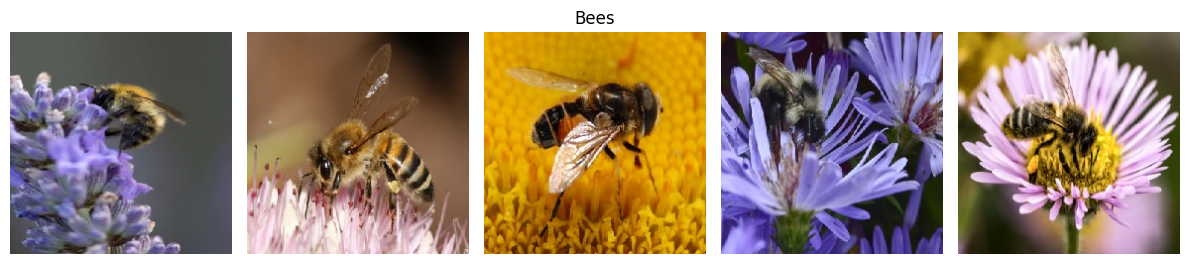

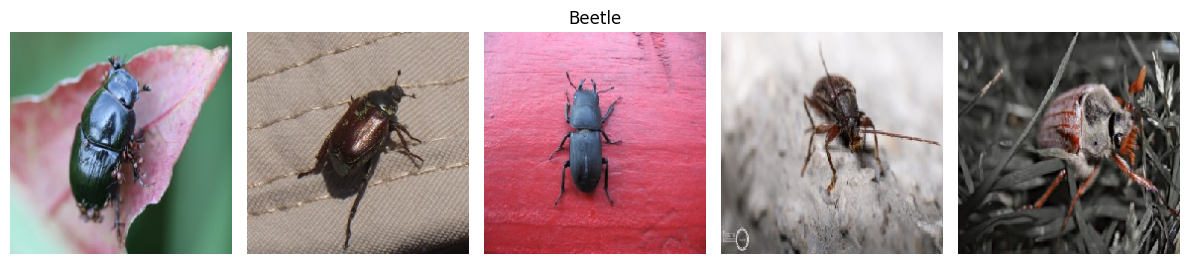

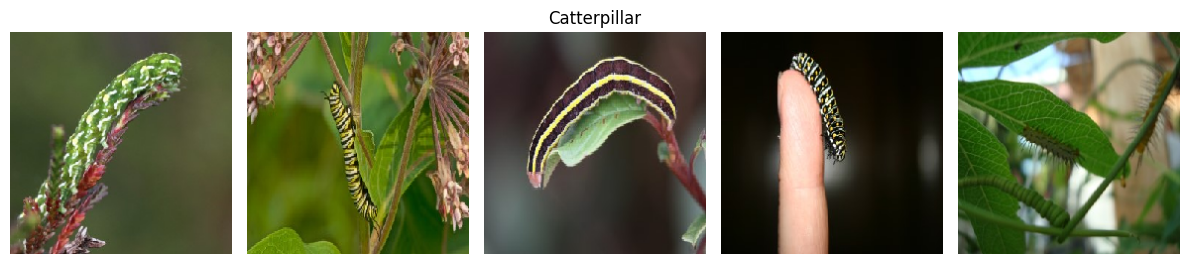

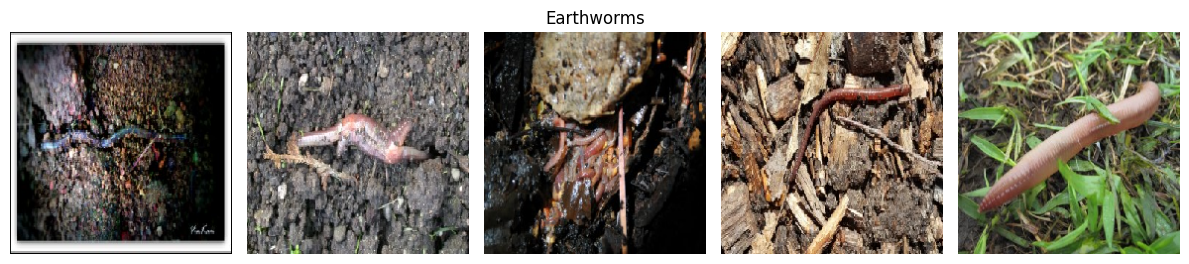

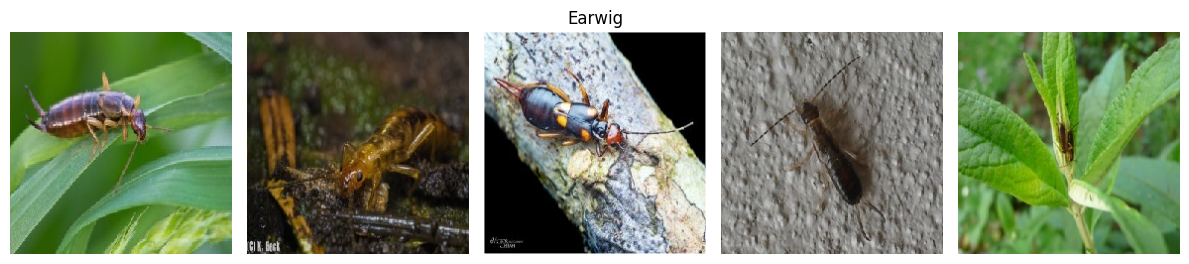

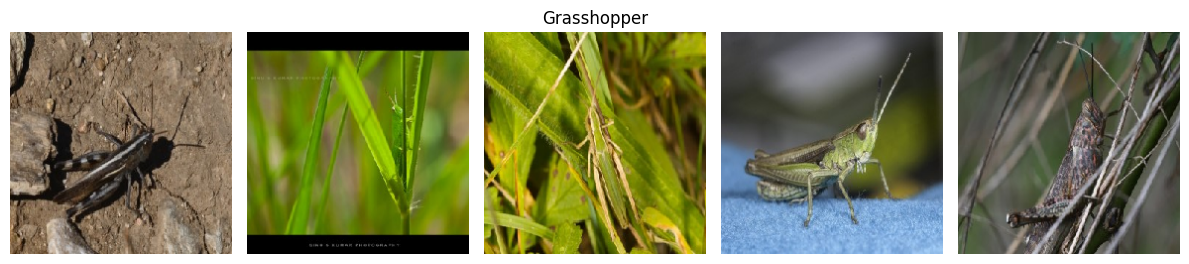

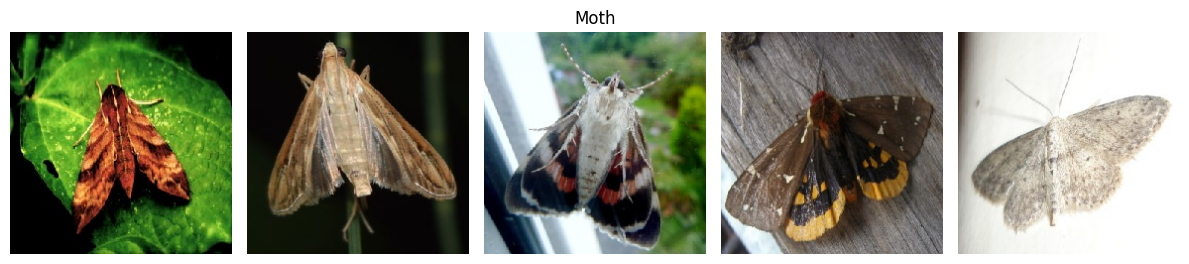

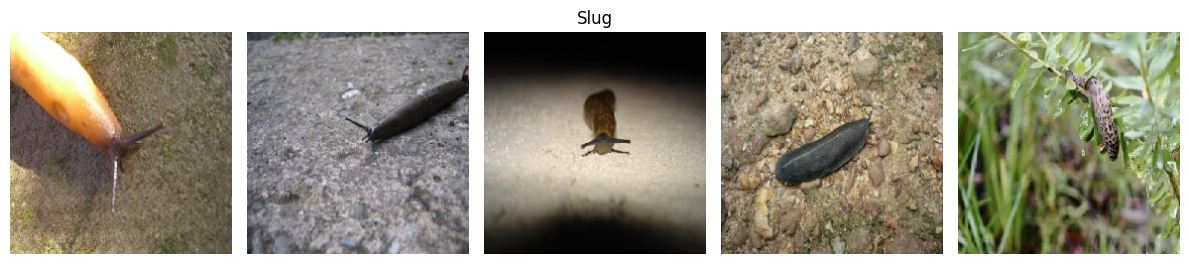

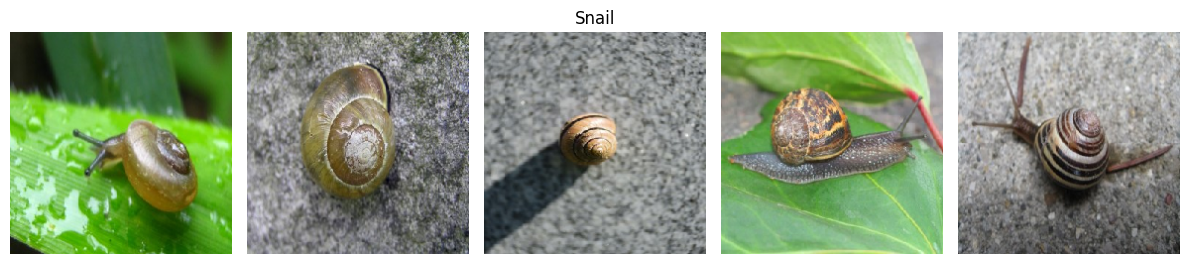

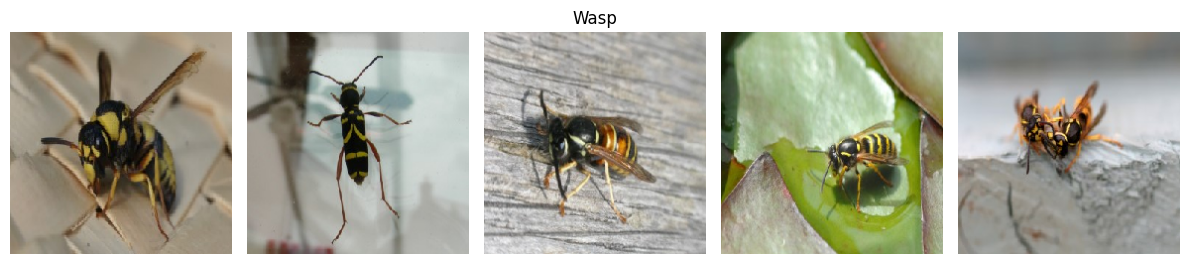

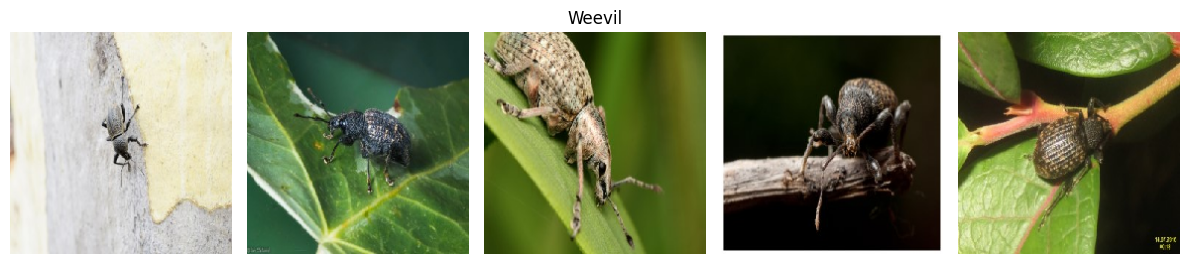

In [6]:
# Loop through each pest subfolder
for folder_name in [i for i in os.listdir(dataset_path)]:
    folder_path = os.path.join(dataset_path, folder_name)

    if os.path.isdir(folder_path):

        # List of images in current folder
        images = [img for img in os.listdir(folder_path)]
        rand_images = random.sample(images, 5)  # Select 5 random images from the folder
        fig, axes = plt.subplots(1, 5, figsize=(12, 6))
        for i, img_name in enumerate(rand_images):
            img_path = os.path.join(folder_path, img_name)
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
            ax = axes[i]
            if i == 2:
                ax.set_title(folder_name.title())  # Centralized title
            ax.imshow(img)
            ax.axis('off')  # Turn of ticks and labels
        plt.tight_layout()
        # plt.savefig(f'../images/{folder_name}_prev.png')
        plt.show()

# Model Creation

In [7]:
def createDenseBlock(prev_layer, n_units: int, dropout_rate: float = None):
    dense_layer = tf.keras.layers.Dense(units=n_units, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01))(prev_layer)
    if dropout_rate:
        dropout_layer = tf.keras.layers.Dropout(rate=dropout_rate)(dense_layer)
        return dropout_layer
    return dense_layer

def create_vgg19(input_shape):
    input_layer = tf.keras.Input(shape=input_shape)
    # Preprocessing input data with vgg19 preprocessing function:
    tensor = tf.keras.applications.vgg19.preprocess_input(input_layer)
    # Model without top classification layers and imagenet weights
    model = tf.keras.applications.vgg19.VGG19(
        include_top=False,
        input_tensor=tensor,
    )
    # Not training the base model parameters
    model.trainable = False
    # Extract features from the preprocessed input data
    features = model(tensor)

    pooling = tf.keras.layers.GlobalAveragePooling2D()(features)
    # Dense blocks
    # Block 1
    dense1 = createDenseBlock(pooling, 64, 0.2)
    # Block 2
    dense2 = createDenseBlock(dense1, 32, 0.2)
    # Output layer
    output = tf.keras.layers.Dense(len(train_ds.class_names), activation='softmax')(dense2)
    # Create model with input and output layers
    model = tf.keras.Model(input_layer, output)
    return model

In [9]:
vgg19 = create_vgg19(input_shape=(img_height, img_width, 3))
vgg19.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                32832 

# Compiling the Model

In [10]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5), # Stop after 5 epochs if val loss doesn't improve
    tf.keras.callbacks.ModelCheckpoint('../models/best_vgg19.h5', monitor='val_accuracy', save_best_only=True)  # Saves best model
]

vgg19.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'],
)

# Training the Model

In [11]:
vgg19_history = vgg19.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks,
)

Epoch 1/10


138/138 [==============================] - 49s 268ms/step - loss: 3.7472 - accuracy: 0.2962 - val_loss: 2.7067 - val_accuracy: 0.5282
Epoch 2/10
138/138 [==============================] - 33s 237ms/step - loss: 2.5784 - accuracy: 0.5093 - val_loss: 2.0356 - val_accuracy: 0.6758
Epoch 3/10
138/138 [==============================] - 34s 244ms/step - loss: 2.0222 - accuracy: 0.6242 - val_loss: 1.6245 - val_accuracy: 0.7641
Epoch 4/10
138/138 [==============================] - 34s 248ms/step - loss: 1.7027 - accuracy: 0.6772 - val_loss: 1.4012 - val_accuracy: 0.7805
Epoch 5/10
138/138 [==============================] - 34s 247ms/step - loss: 1.4186 - accuracy: 0.7366 - val_loss: 1.2419 - val_accuracy: 0.7923
Epoch 6/10
138/138 [==============================] - 34s 247ms/step - loss: 1.2417 - accuracy: 0.7687 - val_loss: 1.1838 - val_accuracy: 0.7832
Epoch 7/10
138/138 [==============================] - 34s 246ms/step - loss: 1.1248 - accuracy: 0.7903 - val_loss: 1.0776 - val_accuracy: 0.8

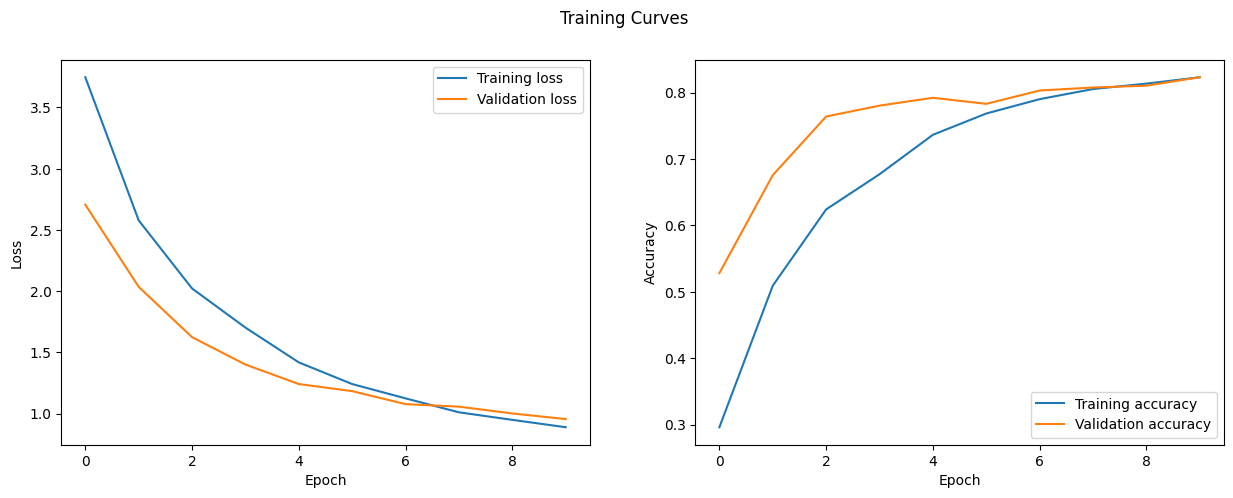

In [12]:
history = vgg19_history.history

plt.figure(figsize=(15, 5))  # Size of the complete figure
plt.subplot(1, 2, 1)  # Select first subplot
plt.plot(history['loss'], label='Training loss') 
plt.plot(history['val_loss'], label='Validation loss')
plt.legend()  # Show the names for the color of lines in plot
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)  # Select second subplot
plt.plot(history['accuracy'], label='Training accuracy')
plt.plot(history['val_accuracy'], label='Validation accuracy')
plt.legend()  # Show the names for the color of lines in plot
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.suptitle('Training Curves')  # Centered title for the figure
plt.show()

In [13]:
def show_performance_evaluation( model, datasets: list):
    for dataset in datasets:
        pred_vals = np.argmax(model.predict(dataset), axis=-1)  # Values for predicted class/category by the model
        true_vals = np.concatenate([label for img, label in dataset], axis=0)
        true_vals = np.argmax(true_vals, axis=-1)  # Values for the actual class (category)

        # ----- Plotting a confusion matrix with seaborn ----- #
        plt.figure(figsize=(7, 7)) 
        class_names = dataset.class_names  
        ax = sns.heatmap(confusion_matrix(true_vals, pred_vals), annot=True, xticklabels=class_names, yticklabels=class_names)  # Seaborn heatmap
        ax.set_title(f"Confusion Matrix: ({len(pred_vals)} samples)")  # Confusion matrix title 
        plt.show()

        print("\n\nClassification Report:\n")
        print(classification_report(true_vals, pred_vals, labels=[i for i in range(0, 3)], target_names=class_names))

138/138 [==============================] - 24s 176ms/step


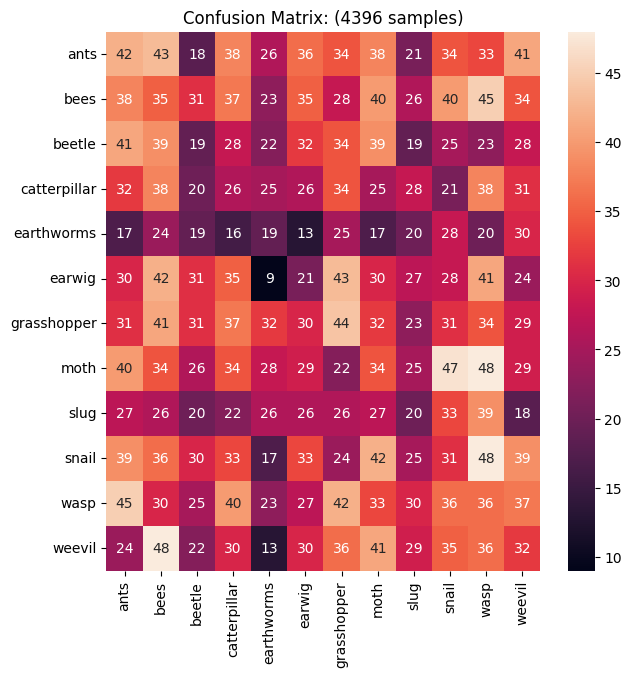



Classification Report:

              precision    recall  f1-score   support

        ants       0.10      0.10      0.10       404
        bees       0.08      0.08      0.08       412
      beetle       0.07      0.05      0.06       349

   micro avg       0.08      0.08      0.08      1165
   macro avg       0.08      0.08      0.08      1165
weighted avg       0.08      0.08      0.08      1165

35/35 [==============================] - 6s 185ms/step


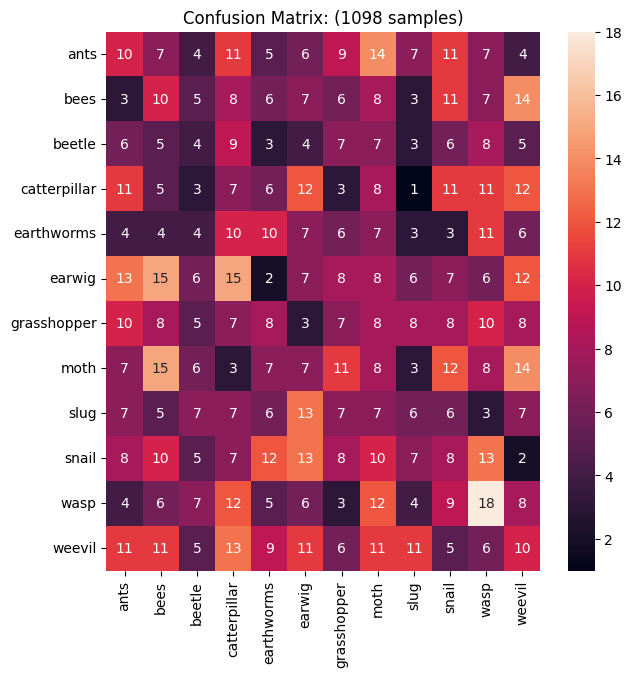



Classification Report:

              precision    recall  f1-score   support

        ants       0.11      0.11      0.11        95
        bees       0.10      0.11      0.11        88
      beetle       0.07      0.06      0.06        67

   micro avg       0.09      0.10      0.09       250
   macro avg       0.09      0.09      0.09       250
weighted avg       0.09      0.10      0.09       250



In [16]:
best_model = tf.keras.models.load_model('../models/best_vgg19.h5')  # Load the model from the saved directory
show_performance_evaluation(datasets=[train_ds, val_ds], model=best_model)